In [88]:
# scikit-learn pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# general and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler        

# import helper functions
import utils as ut

# set random seed for test reproducibility
np.random.seed(42)

# suppress sklearn convergence warning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [89]:
# Evaluation Selection Cell
dataset = 'nasa'    # nasa or wine

# Load data
path = './datasets/'+dataset+'_cla.csv'
df = pd.read_csv(path)

In [90]:
# Split data into training and testing sets
X, y = df.iloc[:,:-1], df.iloc[:,-1]
feature_labels = X.columns
X_train, X_test, y_train_r, y_test_r = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) # 80/20 split

if dataset == 'wine':
    # re-label targets
    y_train = y_train_r - 3 # normalize between [0 - 5]
    y_test = y_test_r - 3 # normalize between [0 - 5]
else:
    y_train = y_train_r
    y_test = y_test_r

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# standardize training and test dataset
scaler = StandardScaler()
scaler.fit_transform(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(y_train.min())

(3749, 17) (3749,)
0


In [91]:
# Find Elbow Point, Trade off Point
from numpy.matlib import repmat
def elbow_point(data):
    curve = data
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)

    return idxOfBestPoint

In [92]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples
import matplotlib.cm as cm

X = X_tr_scaled.copy()
Xt = X_te_scaled.copy()
y = y_train.copy()

cluster_range = np.arange(2, 15, 1)
init_range = 5

# Clustering Algorithms - kmeans:
# resource: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
k_arr = []
for num_cluster in cluster_range:
    inertia_arr = []
    silhouette_arr = []
    for num_init in range(init_range):
        clusterer = KMeans(n_clusters=num_cluster, n_init=1, random_state=num_init)
        cluster_labels = clusterer.fit_predict(X)

        # compute inertia
        inertia_arr.append(clusterer.inertia_)

        # compute silhouette score
        silhouette_avg = silhouette_score(X, cluster_labels)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        silhouette_arr.append(silhouette_avg)

    k_arr.append([inertia_arr,silhouette_arr])

k_arr = np.array(k_arr)
inertia_arr_mean = np.array([k_arr[i,0,:].mean() for i in range(len(cluster_range))])
inertia_arr_std = np.array([k_arr[i,0,:].std() for i in range(len(cluster_range))])
silhouette_arr_mean = np.array([k_arr[i,1,:].mean() for i in range(len(cluster_range))])
silhouette_arr_std = np.array([k_arr[i,1,:].std() for i in range(len(cluster_range))])
d = np.argmax(silhouette_arr_mean) + 2
elbow = elbow_point(inertia_arr_mean) + 2

def K_Means_Results(best_n, X, y):
	kmeans = KMeans(n_clusters=best_n, random_state=42)
	kmeans_labels = kmeans.fit_predict(X)
	print('K-Means Inertia: ', kmeans.inertia_)
	silh_result = silhouette_score(X, kmeans_labels)
	print('K-Means Silhouette score: ', silh_result)
	AMI = adjusted_mutual_info_score(y, kmeans_labels)
	print('K-Means Adjusted Mutual Information (AMI) score: ', AMI)
	print()
	return kmeans_labels

print(d, elbow)
kmean_preds = K_Means_Results(d, X, y)
# kmean_preds_test = K_Means_Results(d, Xt, y_test)

2 6
K-Means Inertia:  48939.21875
K-Means Silhouette score:  0.23058283
K-Means Adjusted Mutual Information (AMI) score:  -0.00023488744035884748



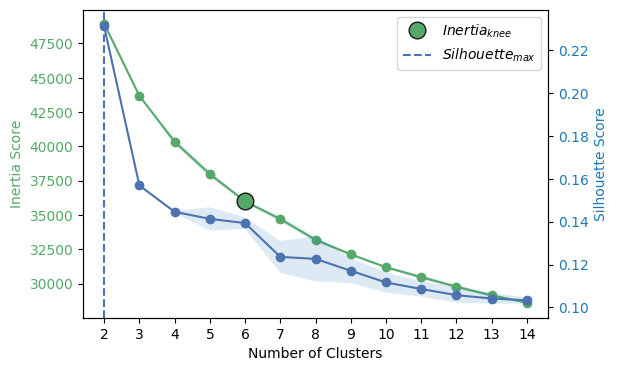

In [93]:
plt.style.use('default')

# visualize K-Means
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(cluster_range, inertia_arr_mean, 'g-o')
ax1.fill_between(cluster_range, inertia_arr_mean - inertia_arr_std, inertia_arr_mean + inertia_arr_std, alpha=0.15)
ax1.set_xticks(cluster_range)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.plot(elbow_point(inertia_arr_mean)+2, inertia_arr_mean[elbow_point(inertia_arr_mean)], 'o', markersize=12, markeredgecolor='k', markerfacecolor='g', label='$Inertia_{knee}$')

ax2 = ax1.twinx()
ax2.plot(cluster_range, silhouette_arr_mean, 'b-o')
ax2.fill_between(cluster_range, silhouette_arr_mean - silhouette_arr_std, silhouette_arr_mean + silhouette_arr_std, alpha=0.15)
ax2.set_ylabel('Silhouette Score', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax1.axvline(np.argmax(silhouette_arr_mean)+2, 0, 30000, color='b', linestyle='--', label='$Silhouette_{max}$')
# ax2.axvline(elbow_point(inertia_arr_mean)+2, 0, 30000, color='g', linestyle='--', label='$Inertia_{knee}$')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
# ax1.grid(visible=None)
# ax2.grid(visible=None)
plt.show()

In [94]:
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
from scipy import linalg

n_components_range = np.arange(2,15, 1)
init_range = 5

X = X_tr_scaled.copy()  
Xt = X_te_scaled.copy()
y = y_train.copy()

# Clustering Algorithms - Gaussian Mixture Model (EM):
# resource: https://colab.research.google.com/github/mbbakalova/Projects/blob/master/Clustering.ipynb#scrollTo=MLTb64iWYvU5
lowest_bic = np.infty
cv_types = ['full'] #['spherical', 'tied', 'diag', 'full']
gmm_arr = []
for n_components in n_components_range:
    bic = []
    aic = []
    silhouette_gmm = []
    for num_init in range(init_range):
        gmm = GaussianMixture(n_components=n_components, n_init=1, random_state=num_init, covariance_type=cv_types[0])
        gmm_labels = gmm.fit_predict(X)
        bic.append(gmm.bic(X))
        aic.append(gmm.aic(X))

        # compute silhouette score
        silhouette_avg = silhouette_score(X, gmm_labels)
        sample_silhouette_values = silhouette_samples(X, gmm_labels)
        silhouette_gmm.append(silhouette_avg)

        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    gmm_arr.append([bic, aic, silhouette_gmm])

gmm_arr = np.array(gmm_arr)
bic_mean = np.array([gmm_arr[i,0,:].mean() for i in range(len(n_components_range))])
bic_std = np.array([gmm_arr[i,0,:].std() for i in range(len(n_components_range))])
aic_mean = np.array([gmm_arr[i,1,:].mean() for i in range(len(n_components_range))])
aic_std = np.array([gmm_arr[i,1,:].std() for i in range(len(n_components_range))])
sil_mean = np.array([gmm_arr[i,2,:].mean() for i in range(len(n_components_range))])
sil_std = np.array([gmm_arr[i,2,:].std() for i in range(len(n_components_range))])
d = np.argmax(sil_mean) + 2
bic_min = np.argmin(bic_mean) + 2

def gmm_results(best_n, X, y):
	gmm_best = GaussianMixture(n_components=best_n, random_state=1)
	gmm_best.fit(X)
	gmm_labels = gmm_best.predict(X)

	print('GMM BIC: ', gmm_best.bic(X))
	score_gmm = silhouette_score(X, gmm_labels)
	print('GMM Silhouette score: ', score_gmm)
	AMI_gmm = adjusted_mutual_info_score(y, gmm_labels)
	print('GMM Adjusted Mutual Information (AMI) score: ', AMI_gmm)
	print()
	return gmm_best.predict_proba(X)

print(d, bic_min)
gmm_preds = gmm_results(bic_min, X, y)
gmm_preds = np.argmax(gmm_preds, axis=1)

2 14
GMM BIC:  -24544.575054821278
GMM Silhouette score:  0.04647034
GMM Adjusted Mutual Information (AMI) score:  0.0257013532224325



In [95]:
# inspect the gradient of the BIC 
plt.plot(np.arange(3, len(np.diff(bic_mean))+3), np.diff(bic_mean), 'k')
plt.errorbar(np.arange(3, len(np.diff(bic_mean))+3), np.diff(bic_mean), yerr=np.abs(np.diff(bic_std)), fmt="", color="k")
# plt.plot(elbow_point(np.diff(bic_mean))+3, np.diff(bic_mean)[elbow_point(np.diff(bic_mean))], 'o', markersize=12, markeredgecolor='k', markerfacecolor='k', label='$Inertia_{knee}$')

<ErrorbarContainer object of 3 artists>

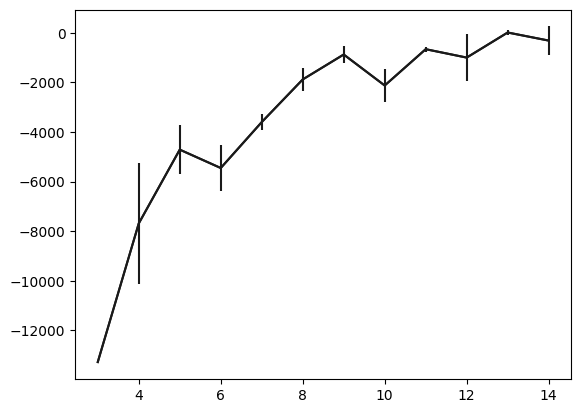

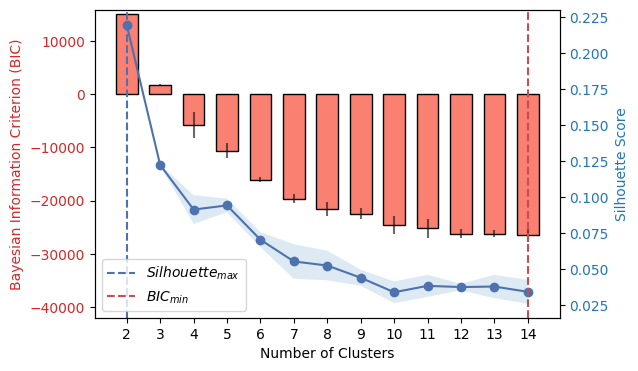

In [96]:
# visualize GMM (EM)
width = 0.65
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.bar(n_components_range, bic_mean, width=width, edgecolor='black', color='salmon')
ax1.errorbar(n_components_range, bic_mean, yerr=bic_std, fmt="none", color="k", alpha=0.65)
# ax1.bar(n_components_range + width/2, aic_mean, width=width, edgecolor='black', color='darkorange', label='AIC')
# ax1.errorbar(n_components_range + width/2, aic_mean, yerr=aic_std, fmt="none", color="k", alpha=0.65)
ax1.set_xticks(n_components_range)
ax1.set_ylim([np.min([bic_mean.min(),aic_mean.min()]) * 1.01 - .01 * np.max([aic_mean.max(),bic_mean.max()]), 1.05* np.max([aic_mean.max(),bic_mean.max()])])
ax1.set_ylabel('Bayesian Information Criterion (BIC)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.plot(n_components_range, sil_mean, 'b-o')
ax2.fill_between(n_components_range, sil_mean - sil_std, sil_mean + sil_std, alpha=0.15)
ax2.set_ylabel('Silhouette Score', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax1.axvline(np.argmax(silhouette_arr_mean) + 2, 0, 30000, color='b', linestyle='--', label='$Silhouette_{max}$')
ax2.axvline(np.argmin(bic_mean) + 2, 0, 30000, color='r', linestyle='--', label='$BIC_{min}$')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax1.set_xlabel('Number of Clusters')
plt.show()

In [97]:
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from scipy.stats import kurtosis
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# # PCA: principle component analysis
X = X_tr_scaled.copy()  

# Define the maximum number of components to test
max_components = min(X.shape[0], X.shape[1])

# Function to compute explained variance
def compute_explained_variance(X, n_components):
    pca = PCA(n_components=n_components, svd_solver='full')
    pca.fit(X)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    explained_variance_ratio = pca.explained_variance_ratio_
    return explained_variance, explained_variance_ratio

# Function to compute reconstruction error
def compute_reconstruction_error(X, n_components):
    pca = PCA(n_components=n_components, svd_solver='full')
    X_transformed = pca.fit_transform(X)
    X_reconstructed = pca.inverse_transform(X_transformed)
    mse = mean_squared_error(X, X_reconstructed)
    return pca, X_transformed, mse

# Initialize lists to store explained variance and reconstruction error
explained_variance_scores = []
reconstruction_errors = []

# Compute explained variance and reconstruction error for different numbers of components
for n_components in range(1, max_components + 1):
    explained_variance, explained_variance_ratio = compute_explained_variance(X, n_components)
    _ , _, reconstruction_error = compute_reconstruction_error(X, n_components)
    explained_variance_scores.append(explained_variance)
    reconstruction_errors.append(reconstruction_error)
d = np.argmax(np.array(explained_variance_scores) >= 0.95) + 1

print(d)
pca_best, X_reduced_pca, recon_mse_pca = compute_reconstruction_error(X, d)
print(pca_best.explained_variance_ratio_)

10
[0.32202753 0.17416291 0.10730237 0.07083859 0.0595597  0.05789444
 0.05563731 0.04650827 0.04000073 0.03081913]


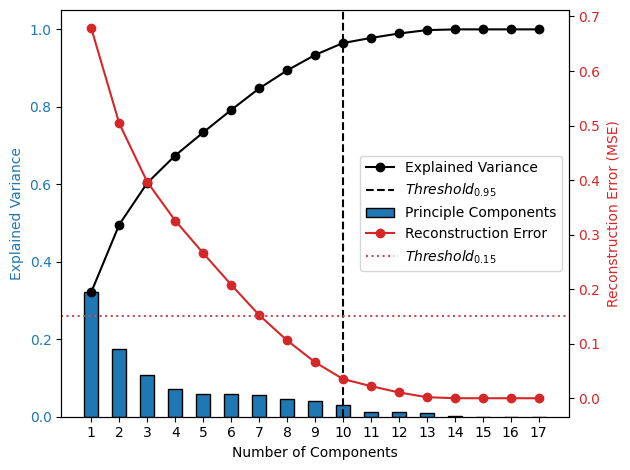

In [98]:
# Plotting the results
fig, ax1 = plt.subplots()

# Plot explained variance
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Explained Variance', color='tab:blue')

ax1.bar(range(1, max_components + 1), explained_variance_ratio, width=0.5, edgecolor='black', label='Principle Components', color='tab:blue')
ax1.plot(range(1, max_components + 1), explained_variance_scores, '-o', label='Explained Variance', color='black')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axvline(d, 0, 1, color='black', linestyle='--',  label='$Threshold_{0.95}$')

# Plot reconstruction errors
ax2 = ax1.twinx()
ax2.set_ylabel('Reconstruction Error (MSE)', color='tab:red')
ax2.plot(range(1, max_components + 1), reconstruction_errors, 'o-', label='Reconstruction Error', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.axhline(0.15, 0, 1, color='r', linestyle=':',  label='$Threshold_{0.15}$')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=5)
fig.tight_layout()
plt.xticks(np.arange(1, max_components + 1))
plt.show()


The rank of the reg dataset is: 16, and of the pca dataset is: 10


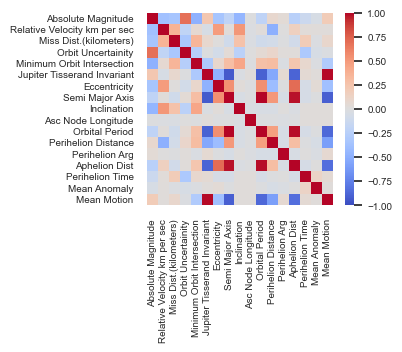

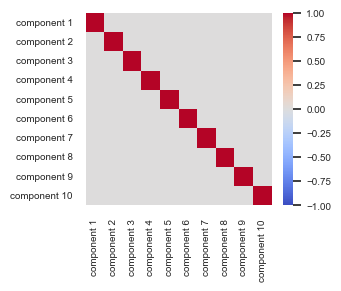

In [99]:
import numpy as np
from numpy.linalg import matrix_rank

# Assuming X is your dataset
rank_reg = matrix_rank(X_tr_scaled)
rank_pca = matrix_rank(X_reduced_pca)
print(f"The rank of the reg dataset is: {rank_reg}, and of the pca dataset is: {rank_pca}")

pca_names = ['component '+str(i+1) for i in range(X_reduced_pca.shape[-1])]
reg_names = ['Feature '+str(i+1) for i in range(X_tr_scaled.shape[-1])]

df_pca = pd.DataFrame(X_reduced_pca, columns=pca_names)
df_reg = pd.DataFrame(X_tr_scaled, columns=feature_labels)
df_pca_corr = df_pca.corr()
df_reg_corr = df_reg.corr()

df_reg_corr = np.round(df_reg_corr,2)
df_pca_corr[df_pca_corr < 1e-5] = 0

scale= 0.65
sns.set(font_scale=scale)
plt.figure(figsize=(3,2.5))
sns.heatmap(df_reg_corr, annot=False, vmax=1, vmin=-1, cmap='coolwarm', annot_kws={"fontsize": 4})
plt.show()

plt.figure(figsize=(3,2.5))
sns.heatmap(df_pca_corr, annot=False, vmax=1, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1/scale)

In [101]:
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.metrics import mean_squared_error
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

X = X_tr_scaled.copy()  

# Define the maximum number of components to test
max_components = min(X.shape[0], X.shape[1])
n_seeds = 1  # Number of different seeds to test

# Function to compute aggregate kurtosis for different numbers of components with different seeds
def compute_kurtosis(X, n_components, random_state=42):
    ica = FastICA(n_components=n_components, random_state=random_state)
    X_reduced = ica.fit_transform(X)
    kurtosis_values = kurtosis(X_reduced, fisher=False)
    return ica, X_reduced, np.mean(kurtosis_values)

# Function to compute reconstruction error with different seeds
def compute_reconstruction_error(X, n_components, random_state):
    ica = FastICA(n_components=n_components, random_state=random_state)
    X_reduced = ica.fit_transform(X)
    reconstruction = X_reduced @ pinv(ica.components_.T)  
    mse = mean_squared_error(X, reconstruction)
    return mse

# Initialize lists to store kurtosis and reconstruction error
kurtosis_scores = np.zeros((max_components, n_seeds))
reconstruction_errors = np.zeros((max_components, n_seeds))

# Compute kurtosis and reconstruction error for different numbers of components and seeds
for n_components in range(1, max_components + 1):
    for seed in range(n_seeds):
        nseed = np.random.randint(0,100000)
        _, _ , kurtosis_scores[n_components - 1, seed] = compute_kurtosis(X, n_components, nseed)
        reconstruction_errors[n_components - 1, seed] = compute_reconstruction_error(X, n_components, nseed)

# Calculate mean and standard deviation
kurtosis_mean = kurtosis_scores.mean(axis=1)
kurtosis_std = kurtosis_scores.std(axis=1)
reconstruction_error_mean = reconstruction_errors.mean(axis=1)
reconstruction_error_std = reconstruction_errors.std(axis=1)

# Identify optimal number of components
d = np.argmax(kurtosis_mean) + 1

if dataset == 'wine':
    d = d
else:
    d = 15

ica_model, X_reduced_ica, kurt_ica = compute_kurtosis(X, d, random_state=42)
kurtosis_values_ica = kurtosis(X_reduced_ica, fisher=False)
idx = np.argsort(kurtosis_values_ica)[::-1]
X_reduced_ica = X_reduced_ica[:,idx]


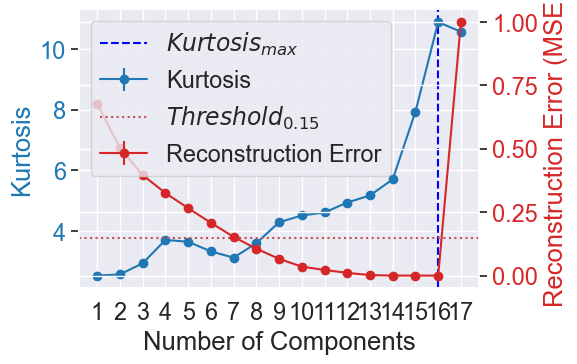

In [102]:
# Plotting the results
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot kurtosis scores
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Kurtosis', color='tab:blue')
ax1.errorbar(range(1, max_components + 1), kurtosis_mean, yerr=kurtosis_std, fmt='-o', label='Kurtosis', color='tab:blue')
# ax1.fill_between(range(1, max_components + 1), kurtosis_mean - kurtosis_std, kurtosis_mean + kurtosis_std, alpha=0.15, label='Kurtosis', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axvline(np.argmax(kurtosis_mean) + 1, 0, 1, color='blue', linestyle='--',  label='$Kurtosis_{max}$')

# Plot reconstruction errors
ax2 = ax1.twinx()
ax2.set_ylabel('Reconstruction Error (MSE)', color='tab:red')
ax2.errorbar(range(1, max_components + 1), reconstruction_error_mean, yerr=reconstruction_error_std, fmt='-o', label='Reconstruction Error', color='tab:red')
# ax2.fill_between(range(1, max_components + 1), reconstruction_error_mean - reconstruction_error_std, reconstruction_error_mean + reconstruction_error_std, alpha=0.15,label='Reconstruction Error', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.axhline(0.15, 0, 25, color='r', linestyle=':', label='$Threshold_{0.15}$')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=2)

plt.xticks(np.arange(1, max_components + 1))
fig.tight_layout()
# plt.title('Evaluation of Optimal Number of Components for ICA')
plt.show()

The rank of the reg dataset is: 16, and of the ica dataset is: 15


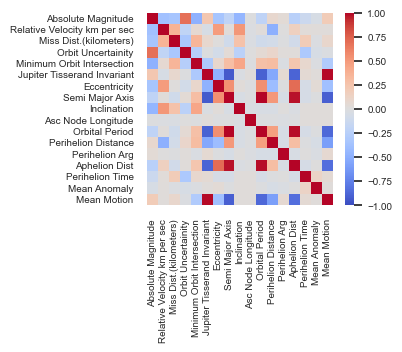

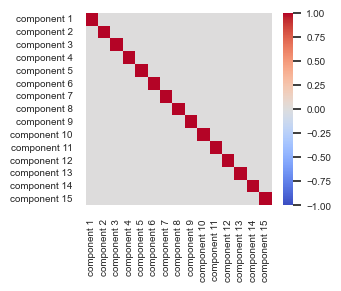

In [103]:
import numpy as np
from numpy.linalg import matrix_rank

# Assuming X is your dataset
rank_reg = matrix_rank(X_tr_scaled)
rank_ica = matrix_rank(X_reduced_ica)
print(f"The rank of the reg dataset is: {rank_reg}, and of the ica dataset is: {rank_ica}")

ica_names = ['component '+str(i+1) for i in range(X_reduced_ica.shape[-1])]
reg_names = ['Feature '+str(i+1) for i in range(X_tr_scaled.shape[-1])]

df_ica = pd.DataFrame(X_reduced_ica, columns=ica_names)
df_reg = pd.DataFrame(X_tr_scaled, columns=feature_labels)
df_ica_corr = df_ica.corr()
df_reg_corr = df_reg.corr()

df_reg_corr = np.round(df_reg_corr,2)
df_ica_corr[df_ica_corr < 1e-5] = 0

scale= 0.65
sns.set(font_scale=scale)
plt.figure(figsize=(3,2.5))
sns.heatmap(df_reg_corr, annot=False, vmax=1, vmin=-1, cmap='coolwarm', annot_kws={"fontsize": 4})
plt.show()

plt.figure(figsize=(3,2.5))
sns.heatmap(df_ica_corr, annot=False, vmax=1, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1/scale)


In [104]:
import numpy as np
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error, pairwise_distances
import matplotlib.pyplot as plt

# RP: random projection
X = X_tr_scaled 

# Define the maximum number of components to test
max_components = min(X.shape[0], X.shape[1])
n_seeds = 5  # Number of different seeds to test

# Function to compute pairwise distance preservation
def compute_distance_preservation(X, n_components, epsilon=1e-10,  random_state=42):
    grp = GaussianRandomProjection(n_components=n_components, random_state=random_state)
    X_proj = grp.fit_transform(X)

    original_distances = pairwise_distances(X)
    projected_distances = pairwise_distances(X_proj)

    # # calculate pairwise mean squared error
    # mse = mean_squared_error(original_distances, projected_distances)

    # Calculate the distortion
    ratios = (projected_distances ** 2) / (original_distances ** 2 + epsilon)
    distortion = np.max(np.abs(ratios - 1))

    return distortion


# Function to compute reconstruction error
def compute_reconstruction_error(X, n_components, random_state=42):
    grp = GaussianRandomProjection(n_components=n_components, random_state=random_state)
    X_proj = grp.fit_transform(X)

    X_reconstructed = X_proj @ np.linalg.pinv(grp.components_).T
    mse = mean_squared_error(X, X_reconstructed)
    return grp, X_proj, mse

# Initialize lists to store metrics
distance_preservations = np.zeros((max_components, n_seeds))
reconstruction_errors = np.zeros((max_components, n_seeds))

# Compute metrics for different numbers of components and seeds
for n_components in range(1, max_components + 1):
    for seed in range(n_seeds):

        # Distance preservation
        distance_preservation = compute_distance_preservation(X, n_components, random_state=seed)
        distance_preservations[n_components - 1, seed] = distance_preservation
        
        # Reconstruction error
        try:
            _, _ , reconstruction_error = compute_reconstruction_error(X, n_components, random_state=seed)
            reconstruction_errors[n_components - 1, seed] = reconstruction_error
        except AttributeError:
            reconstruction_errors[n_components - 1, seed] = np.nan  # GaussianRandomProjection does not support inverse_transform

# Calculate mean and standard deviation
distance_preservation_mean = distance_preservations.mean(axis=1)
distance_preservation_std = distance_preservations.std(axis=1)
reconstruction_error_mean = reconstruction_errors.mean(axis=1)
reconstruction_error_std = reconstruction_errors.std(axis=1)
elbow = elbow_point(distance_preservation_mean) + 1

if dataset == 'wine':
    d = 9
else:
    d = 15

rp_model, X_reduced_rp, recon_mse_rp = compute_reconstruction_error(X, d, random_state=42)

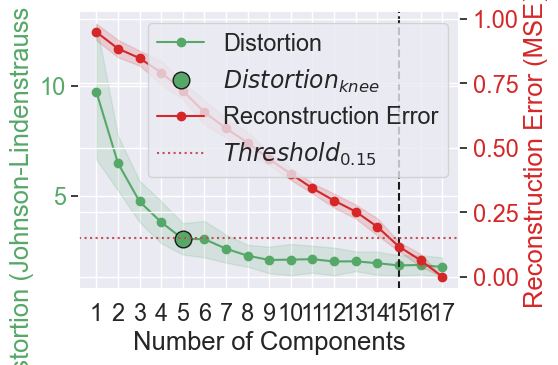

In [105]:
# Plotting the results
fig, ax1 = plt.subplots(figsize=(6,4))

# Plot distance preservation
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Distortion (Johnson-Lindenstrauss Lemma)', color='g')
# ax1.errorbar(range(1, max_components + 1), distance_preservation_mean, yerr=distance_preservation_std, fmt='-o', label='Distance Preservation', color='tab:blue')
ax1.plot(range(1, max_components + 1), distance_preservation_mean, '-o', label='Distortion', color='g')
ax1.fill_between(range(1, max_components + 1), distance_preservation_mean - distance_preservation_std, distance_preservation_mean + distance_preservation_std, alpha=0.15, color='g')
ax1.tick_params(axis='y', labelcolor='g')
# ax1.axvline(d, 0, 100, color='black', linestyle='--')
ax1.plot(elbow_point(distance_preservation_mean)+1, distance_preservation_mean[elbow_point(distance_preservation_mean)], 'o', markersize=12, markeredgecolor='k', markerfacecolor='g', label='$Distortion_{knee}$')

# Plot reconstruction errors
ax2 = ax1.twinx()
ax2.set_ylabel('Reconstruction Error (MSE)', color='tab:red')
# ax2.errorbar(range(1, max_components + 1), reconstruction_error_mean, yerr=reconstruction_error_std, fmt='-o', label='Reconstruction Error', color='tab:red')
ax2.plot(range(1, max_components + 1), reconstruction_error_mean,  '-o', label='Reconstruction Error', color='tab:red')
ax2.fill_between(range(1, max_components + 1), reconstruction_error_mean - reconstruction_error_std, reconstruction_error_mean + reconstruction_error_std, alpha=0.15, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.axhline(0.15, 0, 25, color='r', linestyle=':', label='$Threshold_{0.15}$' )
ax1.axvline(d, 0, 25, color='k', linestyle='--')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.xticks(np.arange(1, max_components + 1))
fig.tight_layout()
plt.show()

The rank of the reg dataset is: 16, and of the pca dataset is: 15


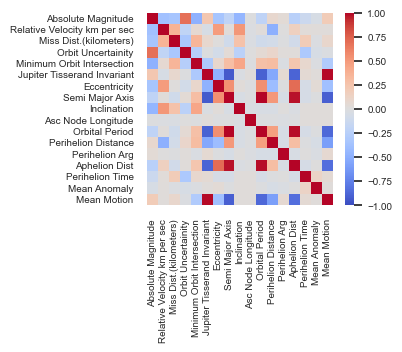

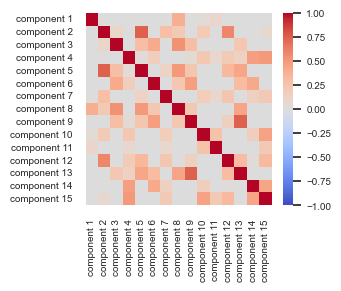

In [107]:
import numpy as np
from numpy.linalg import matrix_rank

# Assuming X is your dataset
rank_reg = matrix_rank(X_tr_scaled)
rank_rp = matrix_rank(X_reduced_rp)
print(f"The rank of the reg dataset is: {rank_reg}, and of the pca dataset is: {rank_rp}")

rp_names = ['component '+str(i+1) for i in range(X_reduced_rp.shape[-1])]
reg_names = ['Feature '+str(i+1) for i in range(X_tr_scaled.shape[-1])]

df_rp = pd.DataFrame(X_reduced_rp, columns=rp_names)
df_reg = pd.DataFrame(X_tr_scaled, columns=feature_labels)
df_rp_corr = df_rp.corr()
df_reg_corr = df_reg.corr()

df_reg_corr = np.round(df_reg_corr,2)
df_rp_corr[df_rp_corr < 1e-5] = 0

scale= 0.65
sns.set(font_scale=scale)
plt.figure(figsize=(3,2.5))
sns.heatmap(df_reg_corr, annot=False, vmax=1, vmin=-1, cmap='coolwarm', annot_kws={"fontsize": 4})
plt.show()

plt.figure(figsize=(3,2.5))
sns.heatmap(df_rp_corr, annot=False, vmax=1, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1/scale)


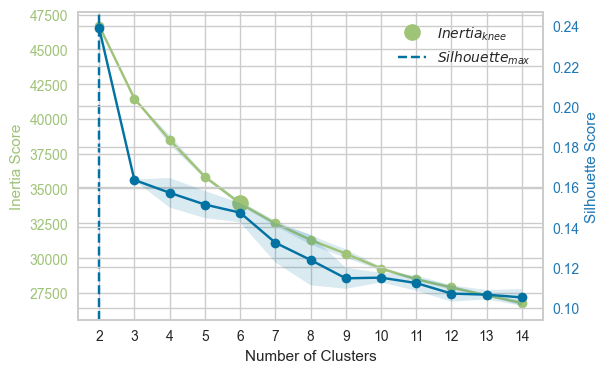

0 2 6
K-Means Inertia:  46696.55859375
K-Means Silhouette score:  0.24110623
K-Means Adjusted Mutual Information (AMI) score:  -0.00024095802220335842



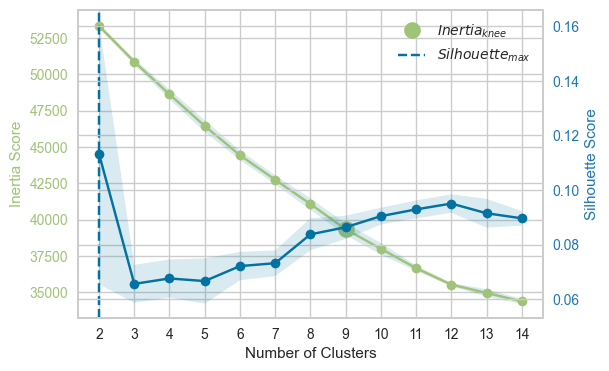

1 2 9
K-Means Inertia:  53372.32421875
K-Means Silhouette score:  0.05823359
K-Means Adjusted Mutual Information (AMI) score:  0.0018808322942139044



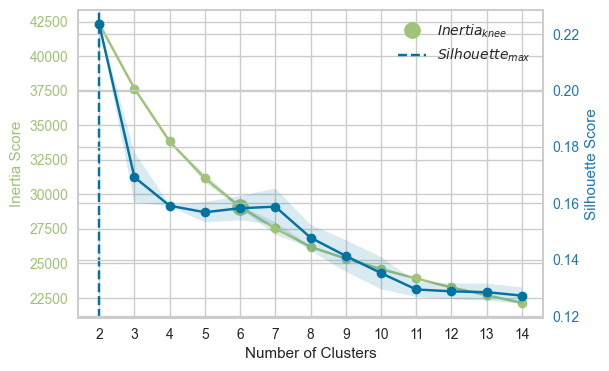

2 2 6
K-Means Inertia:  42339.51171875
K-Means Silhouette score:  0.22354995
K-Means Adjusted Mutual Information (AMI) score:  0.0008492306029683951



In [ ]:
reduced_sets = [X_reduced_pca, X_reduced_ica, X_reduced_rp]

for i, X_train in enumerate(reduced_sets):
    X = X_train.copy()
    y = y_train.copy()

    cluster_range = np.arange(2, 15, 1)
    init_range = 5

    # Clustering Algorithms - kmeans:
    # resource: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
    k_arr = []
    for num_cluster in cluster_range:
        inertia_arr = []
        silhouette_arr = []
        for num_init in range(init_range):
            clusterer = KMeans(n_clusters=num_cluster, n_init=1, random_state=num_init)
            cluster_labels = clusterer.fit_predict(X)

            # compute inertia
            inertia_arr.append(clusterer.inertia_)

            # compute silhouette score
            silhouette_avg = silhouette_score(X, cluster_labels)
            sample_silhouette_values = silhouette_samples(X, cluster_labels)
            silhouette_arr.append(silhouette_avg)

        k_arr.append([inertia_arr,silhouette_arr])

    k_arr = np.array(k_arr)
    inertia_arr_mean = np.array([k_arr[i,0,:].mean() for i in range(len(cluster_range))])
    inertia_arr_std = np.array([k_arr[i,0,:].std() for i in range(len(cluster_range))])
    silhouette_arr_mean = np.array([k_arr[i,1,:].mean() for i in range(len(cluster_range))])
    silhouette_arr_std = np.array([k_arr[i,1,:].std() for i in range(len(cluster_range))])
    d = np.argmax(silhouette_arr_mean) + 2
    elbow = elbow_point(inertia_arr_mean) + 2

    # visualize K-Means
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(cluster_range, inertia_arr_mean, 'g-o')
    ax1.fill_between(cluster_range, inertia_arr_mean - inertia_arr_std, inertia_arr_mean + inertia_arr_std, alpha=0.15)
    ax1.set_xticks(cluster_range)
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia Score', color='g')
    ax1.tick_params(axis='y', labelcolor='g')
    ax1.plot(elbow_point(inertia_arr_mean)+2, inertia_arr_mean[elbow_point(inertia_arr_mean)], 'o', markersize=12, markeredgecolor='k', markerfacecolor='g', label='$Inertia_{knee}$')     
    ax2 = ax1.twinx()
    ax2.plot(cluster_range, silhouette_arr_mean, 'b-o')
    ax2.fill_between(cluster_range, silhouette_arr_mean - silhouette_arr_std, silhouette_arr_mean + silhouette_arr_std, alpha=0.15)
    ax2.set_ylabel('Silhouette Score', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')           
    ax1.axvline(np.argmax(silhouette_arr_mean)+2, 0, 30000, color='b', linestyle='--', label='$Silhouette_{max}$')
    # ax2.axvline(elbow_point(inertia_arr_mean)+2, 0, 30000, color='g', linestyle='--', label='$Inertia_{knee}$')
    plt.xticks(cluster_range)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.show()

    print(i, d, elbow)
    K_Means_Results(d, X, y)

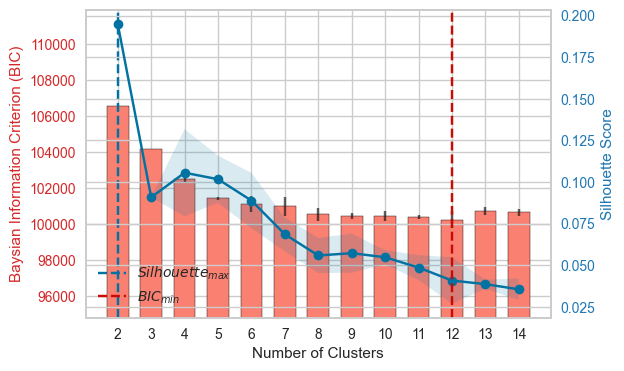

0 2 12
GMM BIC:  106598.4217550115
GMM Silhouette score:  0.19475228
GMM Adjusted Mutual Information (AMI) score:  0.002518531860397499



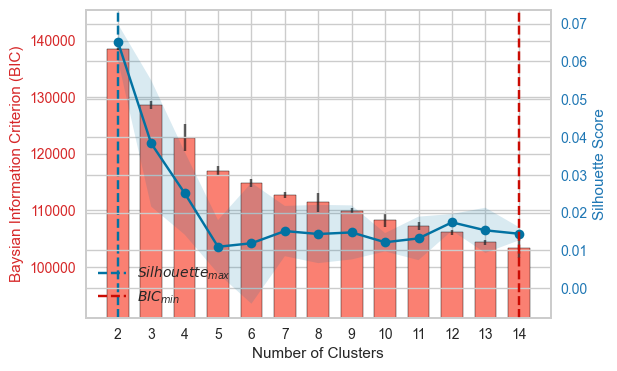

1 2 14
GMM BIC:  138192.37048034812
GMM Silhouette score:  0.05899199
GMM Adjusted Mutual Information (AMI) score:  0.0010988480292715482



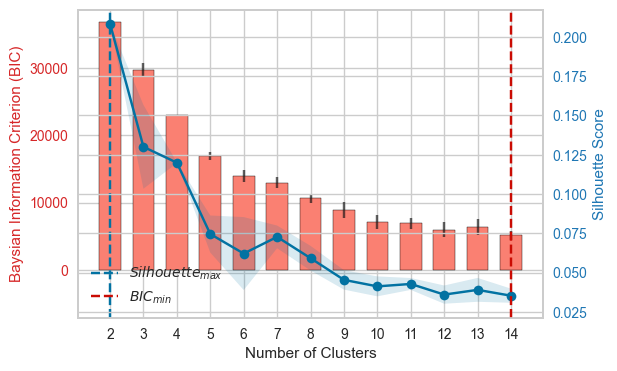

2 2 14
GMM BIC:  36812.8045766538
GMM Silhouette score:  0.20834944
GMM Adjusted Mutual Information (AMI) score:  -0.00010021660967245139



In [ ]:
reduced_sets = [X_reduced_pca, X_reduced_ica, X_reduced_rp]
model_sets = [pca_best, ica_model, rp_model]
cluster_sets = [kmean_preds, gmm_preds]

for i, X_train in enumerate(reduced_sets):
    X = X_train.copy()
    y = y_train.copy()

    n_components_range = np.arange(2, 15, 1)
    init_range = 5

    # Clustering Algorithms - Gaussian Mixture Model (EM):
    # resource: https://colab.research.google.com/github/mbbakalova/Projects/blob/master/Clustering.ipynb#scrollTo=MLTb64iWYvU5
    lowest_bic = np.infty
    cv_types = ['full'] #['spherical', 'tied', 'diag', 'full']
    gmm_arr = []
    for n_components in n_components_range:
        bic = []
        aic = []
        silhouette_gmm = []
        for num_init in range(init_range):
            gmm = GaussianMixture(n_components=n_components, n_init=1, random_state=num_init, covariance_type=cv_types[0])
            gmm_labels = gmm.fit_predict(X)
            bic.append(gmm.bic(X))
            aic.append(gmm.aic(X))

            # compute silhouette score
            silhouette_avg = silhouette_score(X, gmm_labels)
            sample_silhouette_values = silhouette_samples(X, gmm_labels)
            silhouette_gmm.append(silhouette_avg)

            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
        gmm_arr.append([bic, aic, silhouette_gmm])

    gmm_arr = np.array(gmm_arr)
    bic_mean = np.array([gmm_arr[i,0,:].mean() for i in range(len(n_components_range))])
    bic_std = np.array([gmm_arr[i,0,:].std() for i in range(len(n_components_range))])
    aic_mean = np.array([gmm_arr[i,1,:].mean() for i in range(len(n_components_range))])
    aic_std = np.array([gmm_arr[i,1,:].std() for i in range(len(n_components_range))])
    sil_mean = np.array([gmm_arr[i,2,:].mean() for i in range(len(n_components_range))])
    sil_std = np.array([gmm_arr[i,2,:].std() for i in range(len(n_components_range))])
    d = np.argmax(sil_mean) + 2
    bic_min = np.argmin(bic_mean) + 2

    # visualize GMM (EM)
    width = 0.65
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.bar(n_components_range, bic_mean, width=width, edgecolor='black', color='salmon')
    ax1.errorbar(n_components_range, bic_mean, yerr=bic_std, fmt="none", color="k", alpha=0.65)
    # ax1.bar(n_components_range + width/2, aic_mean, width=width, edgecolor='black', color='darkorange', label='AIC')
    # ax1.errorbar(n_components_range + width/2, aic_mean, yerr=aic_std, fmt="none", color="k", alpha=0.65)
    ax1.set_xticks(n_components_range)
    ax1.set_ylim([np.min([bic_mean.min(),aic_mean.min()]) * 1.01 - .01 * np.max([aic_mean.max(),bic_mean.max()]), 1.05* np.max([aic_mean.max(),bic_mean.max()])])
    ax1.set_ylabel('Baysian Information Criterion (BIC)', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax1.twinx()
    ax2.plot(n_components_range, sil_mean, 'b-o')
    ax2.fill_between(n_components_range, sil_mean - sil_std, sil_mean + sil_std, alpha=0.15)
    ax2.set_ylabel('Silhouette Score', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')   
    ax1.axvline(np.argmax(silhouette_arr_mean) + 2, 0, 30000, color='b', linestyle='--', label='$Silhouette_{max}$')
    ax2.axvline(np.argmin(bic_mean) + 2, 0, 30000, color='r', linestyle='--', label='$BIC_{min}$')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    ax1.set_xlabel('Number of Clusters')  
    plt.show()
    
    print(i, d, bic_min)
    gmm_results(d, X, y)


In [ ]:
cluster_sets = [kmean_preds, gmm_preds]

import pickle
def save_object(obj, filename):
    """Save a Python object to a file using pickle."""
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

def load_object(filename):
    """Load a Python object from a pickle file."""
    with open(filename, 'rb') as file:
        return pickle.load(file)

if dataset == 'wine':
    # save_object([model_sets, reduced_sets, cluster_sets], 'reduced_dim_sets_wine.pkl')
    dimred_models, X_reduced_set, X_cluster_set = load_object('reduced_dim_sets_wine.pkl')
else:
    # save_object([model_sets, reduced_sets], 'reduced_dim_sets_nasa.pkl')
    dimred_models, X_reduced_set = load_object('reduced_dim_sets_nasa.pkl')

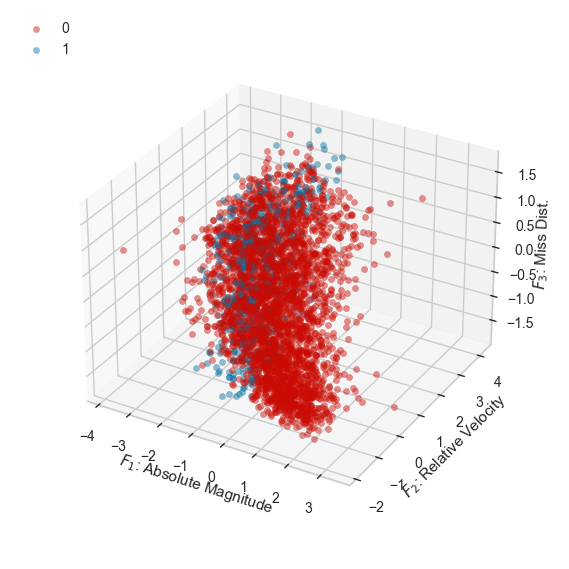

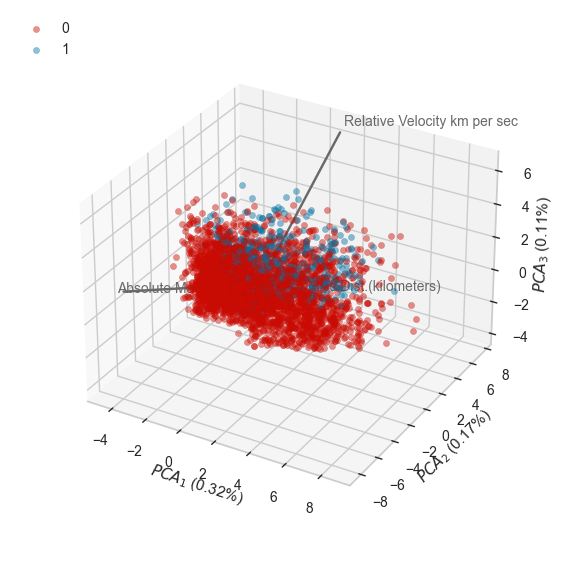

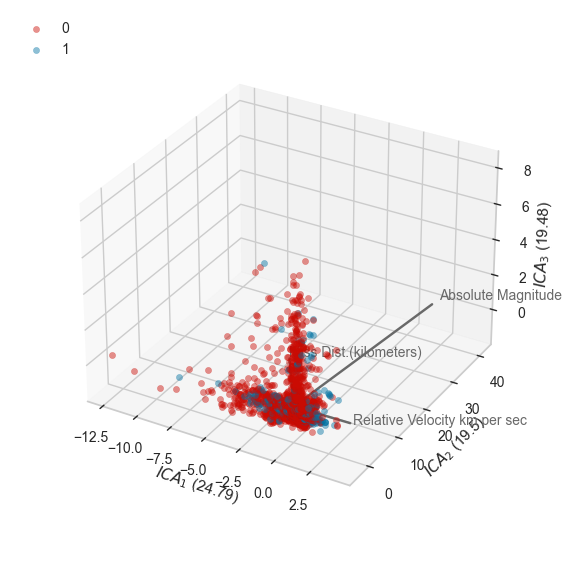

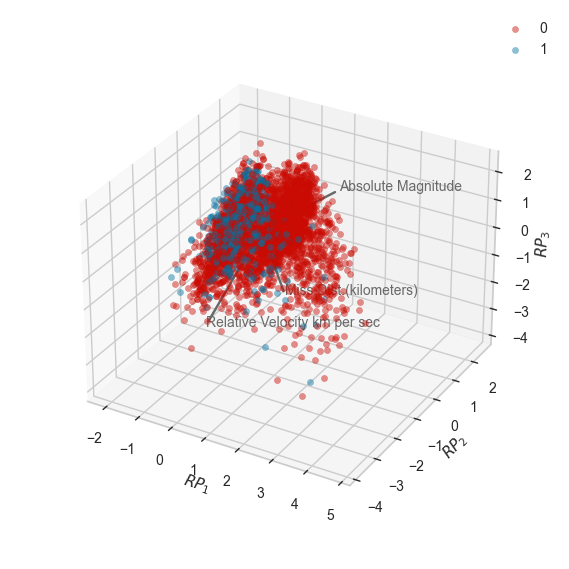

In [ ]:
def Plot_2d(Z,Y): 
    for i in range(len(Y)):
        if Y[i] == 0:
            plt.scatter(Z[i, 1], Z[i, 0], c = 'r', alpha=0.25, label='0')
        elif Y[i] == 1:
            plt.scatter(Z[i, 1], Z[i, 0], c = 'b', alpha=0.25, label='1')
        elif Y[i] == 2:
            plt.scatter(Z[i, 1], Z[i, 0], c = 'g', alpha=0.25, label='2')
        elif Y[i] == 3:
            plt.scatter(Z[i, 1], Z[i, 0], c = 'k', alpha=0.25, label='3')
        elif Y[i] == 4:
            plt.scatter(Z[i, 1], Z[i, 0], c = 'y', alpha=0.25, label='4')
        elif Y[i] == 5:
            plt.scatter(Z[i, 1], Z[i, 0], c = 'm', alpha=0.25, label='5')
    
    plt.show()

def project_components(ax, model, Xp, feature_labels):
    x_vector = model.components_[0]
    y_vector = model.components_[1]
    z_vector = model.components_[2]
    max_x = max(Xp[:, 0]) * 3
    max_y = max(Xp[:, 1]) * 3
    max_z = max(Xp[:, 1]) * 3
    
    # for i in range(model.components_.shape[1]):
    for i in range(3):
        ax.plot(
            [0, x_vector[i] * max_x],
            [0, y_vector[i] * max_y],
            [0, z_vector[i] * max_z],
            color="dimgrey",
        )
        ax.text(
            x_vector[i] * max_x * 1.05,
            y_vector[i] * max_y * 1.05,
            z_vector[i] * max_z * 1.05,
            feature_labels[i],
            color="dimgrey",
            fontsize=10,
        )


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Regular scaled features 
Z = X_tr_scaled
Y = y_train.values

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Dictionary to store scatter handles for legend
scatter_handles = {}

for i in range(len(Y)):
    if Y[i] == 0:
        scatter_handles[0] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='r', marker='o', alpha=0.45)
    elif Y[i] == 1:
        scatter_handles[1] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='b', marker='o', alpha=0.45)
    elif Y[i] == 2:
        scatter_handles[2] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='g', marker='o', alpha=0.45)
    elif Y[i] == 3:
        scatter_handles[3] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='k', marker='o', alpha=0.45)
    elif Y[i] == 4:
        scatter_handles[4] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='y', marker='o', alpha=0.45)
    elif Y[i] == 5:
        scatter_handles[5] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='m', marker='o', alpha=0.45)

# Add legend
if dataset == 'wine':
    ax.legend([scatter_handles[0], scatter_handles[1], scatter_handles[2], scatter_handles[3], scatter_handles[4], scatter_handles[5]], 
            ['0', '1', '2', '3', '4', '5'], loc='upper left')
elif dataset == 'nasa':
    ax.legend([scatter_handles[0], scatter_handles[1]], 
            ['0', '1'], loc='upper left')

vals = [str(i) for i in explained_variance_ratio[:3].tolist()]

if dataset == 'wine':
    ax.set(xlabel=(r'$F_1$: Fixed Acidity'), 
        ylabel=(r'$F_2$: Volatile Acidity'), 
        zlabel=(r'$F_3$: Citric Acid'))
elif dataset == 'nasa':
    ax.set(xlabel=(r'$F_1$: Absolute Magnitude'), 
        ylabel=(r'$F_2$: Relative Velocity'), 
        zlabel=(r'$F_3$: Miss Dist.'))

ax.set_box_aspect(None, zoom=0.85)
fig.tight_layout(pad=0)
fig.subplots_adjust(top=1, bottom=0, left=-0.2, right=1)
plt.show()


# PCA components
# Assuming X_reduced_set[0] and y_train.values are already defined
Z = X_reduced_set[0]
Y = y_train.values
feature_labels = X_train.columns

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Dictionary to store scatter handles for legend
scatter_handles = {}

for i in range(len(Y)):
    if Y[i] == 0:
        scatter_handles[0] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='r', marker='o', alpha=0.45)
    elif Y[i] == 1:
        scatter_handles[1] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='b', marker='o', alpha=0.45)
    elif Y[i] == 2:
        scatter_handles[2] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='g', marker='o', alpha=0.45)
    elif Y[i] == 3:
        scatter_handles[3] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='k', marker='o', alpha=0.45)
    elif Y[i] == 4:
        scatter_handles[4] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='y', marker='o', alpha=0.45)
    elif Y[i] == 5:
        scatter_handles[5] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='m', marker='o', alpha=0.45)

project_components(ax, dimred_models[0], Z, feature_labels)

# Add legend
if dataset == 'wine':
    ax.legend([scatter_handles[0], scatter_handles[1], scatter_handles[2], scatter_handles[3], scatter_handles[4], scatter_handles[5]], 
            ['0', '1', '2', '3', '4', '5'], loc='upper left')
elif dataset == 'nasa':
    ax.legend([scatter_handles[0], scatter_handles[1]], 
            ['0', '1'], loc='upper left')

vals = [str(i) for i in explained_variance_ratio[:3].tolist()]
ax.set(xlabel=(r'$PCA_1 $ (' + str(np.round(explained_variance_ratio[0], 2)) + '%)'), 
       ylabel=(r'$PCA_2 $ (' + str(np.round(explained_variance_ratio[1], 2)) + '%)'), 
       zlabel=(r'$PCA_3 $ (' + str(np.round(explained_variance_ratio[2], 2)) + '%)'))

ax.set_box_aspect(None, zoom=0.85)
fig.tight_layout(pad=0)
fig.subplots_adjust(top=1, bottom=0, left=-0.2, right=1)
# fig.subplots_adjust(left=-0.20)  # plot outside the normal area
# ax.view_init(elev=30, azim=45, roll=15)
plt.show()


# ICA components
# Assuming X_reduced_set[0] and y_train.values are already defined
Z = X_reduced_set[1]
Y = y_train.values

Z_kurt = kurtosis(Z, fisher=False)
idx = np.argsort(Z_kurt)[::-1]
Z = Z[:,idx]
Z_kurt = kurtosis(Z, fisher=False)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Dictionary to store scatter handles for legend
scatter_handles = {}

for i in range(len(Y)):
    if Y[i] == 0:
        scatter_handles[0] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='r', marker='o', alpha=0.45)
    elif Y[i] == 1:
        scatter_handles[1] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='b', marker='o', alpha=0.45)
    elif Y[i] == 2:
        scatter_handles[2] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='g', marker='o', alpha=0.45)
    elif Y[i] == 3:
        scatter_handles[3] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='k', marker='o', alpha=0.45)
    elif Y[i] == 4:
        scatter_handles[4] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='y', marker='o', alpha=0.45)
    elif Y[i] == 5:
        scatter_handles[5] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='m', marker='o', alpha=0.45)

project_components(ax, dimred_models[1], Z, feature_labels)

# Add legend
if dataset == 'wine':
    ax.legend([scatter_handles[0], scatter_handles[1], scatter_handles[2], scatter_handles[3], scatter_handles[4], scatter_handles[5]], 
            ['0', '1', '2', '3', '4', '5'], loc='upper left')
elif dataset == 'nasa':
    ax.legend([scatter_handles[0], scatter_handles[1]], 
            ['0', '1'], loc='upper left')

vals = [str(i) for i in Z_kurt[:3].tolist()]
ax.set(xlabel=(r'$ICA_1 $ (' + str(np.round(Z_kurt[0], 2)) + ')'), 
       ylabel=(r'$ICA_2 $ (' + str(np.round(Z_kurt[1], 2)) + ')'), 
       zlabel=(r'$ICA_3 $ (' + str(np.round(Z_kurt[2], 2)) + ')'))

ax.set_box_aspect(None, zoom=0.85)
fig.tight_layout(pad=0)
fig.subplots_adjust(top=1, bottom=0, left=-0.2, right=1)
# fig.subplots_adjust(left=-0.20)  # plot outside the normal area
plt.show()


# RP components
# Assuming X_reduced_set[0] and y_train.values are already defined
Z = X_reduced_set[2]
Y = y_train.values

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Dictionary to store scatter handles for legend
scatter_handles = {}

for i in range(len(Y)):
    if Y[i] == 0:
        scatter_handles[0] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='r', marker='o', alpha=0.45)
    elif Y[i] == 1:
        scatter_handles[1] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='b', marker='o', alpha=0.45)
    elif Y[i] == 2:
        scatter_handles[2] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='g', marker='o', alpha=0.45)
    elif Y[i] == 3:
        scatter_handles[3] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='k', marker='o', alpha=0.45)
    elif Y[i] == 4:
        scatter_handles[4] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='y', marker='o', alpha=0.45)
    elif Y[i] == 5:
        scatter_handles[5] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='m', marker='o', alpha=0.45)

project_components(ax, dimred_models[2], Z, feature_labels)

# Add legend
if dataset == 'wine':
    ax.legend([scatter_handles[0], scatter_handles[1], scatter_handles[2], scatter_handles[3], scatter_handles[4], scatter_handles[5]], 
            ['0', '1', '2', '3', '4', '5'], loc='upper left')
elif dataset == 'nasa':
    ax.legend([scatter_handles[0], scatter_handles[1]], 
            ['0', '1'])

ax.set(xlabel=(r'$RP_1 $'), 
       ylabel=(r'$RP_2 $'), 
       zlabel=(r'$RP_3 $'))

ax.set_box_aspect(None, zoom=0.85)
fig.tight_layout(pad=0)
fig.subplots_adjust(top=1, bottom=0, left=-0.2, right=1)
# fig.subplots_adjust(left=-0.20)  # plot outside the normal area
plt.show()


In [ ]:
X_train.columns

Index(['Absolute Magnitude', 'Relative Velocity km per sec',
       'Miss Dist.(kilometers)', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Eccentricity', 'Semi Major Axis', 'Inclination', 'Asc Node Longitude',
       'Orbital Period', 'Perihelion Distance', 'Perihelion Arg',
       'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion'],
      dtype='object')

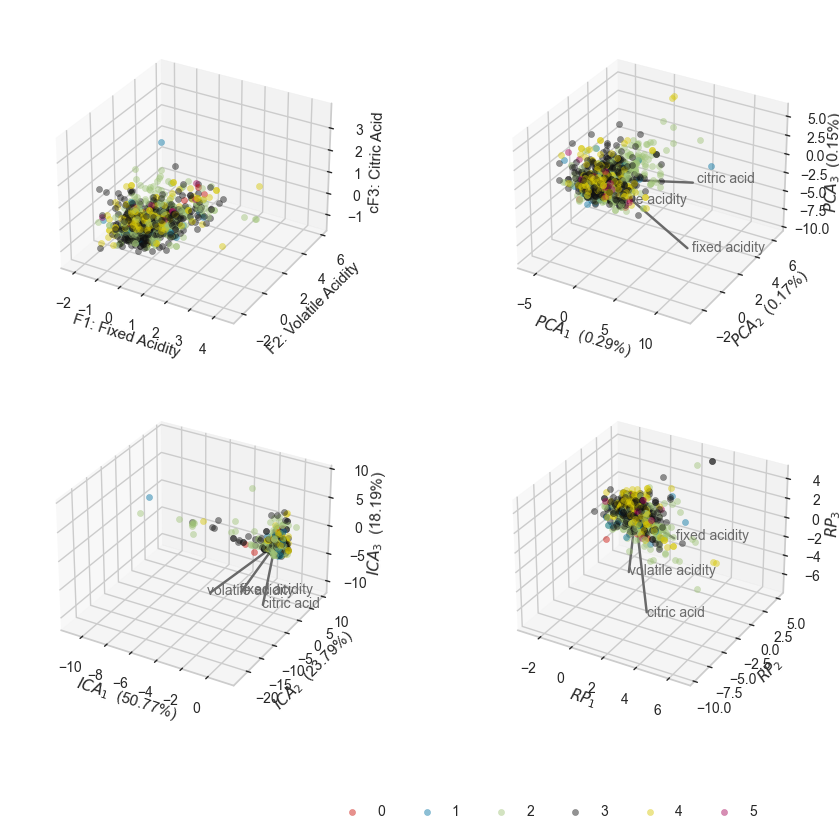

In [ ]:
# Regular scaled features
Z1 = X_tr_scaled
Y = y_train.values

# PCA components
Z2 = X_reduced_set[0]

# ICA components
Z3 = X_reduced_set[1]
Z_kurt = kurtosis(Z3, fisher=False)
idx = np.argsort(Z_kurt)[::-1]
Z3 = Z3[:, idx]
Z_kurt = kurtosis(Z3, fisher=False)

# RP components
Z4 = X_reduced_set[2]

fig, axs = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(10,8))
scatter_handles = {}

# Plotting function to avoid code repetition
def plot_3d_scatter(ax, Z, title, xlabel, ylabel, zlabel, explained_var=None):
    for i in range(len(Y)):
        if Y[i] == 0:
            scatter_handles[0] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='r', marker='o', alpha=0.45)
        elif Y[i] == 1:
            scatter_handles[1] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='b', marker='o', alpha=0.45)
        elif Y[i] == 2:
            scatter_handles[2] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='g', marker='o', alpha=0.45)
        elif Y[i] == 3:
            scatter_handles[3] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='k', marker='o', alpha=0.45)
        elif Y[i] == 4:
            scatter_handles[4] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='y', marker='o', alpha=0.45)
        elif Y[i] == 5:
            scatter_handles[5] = ax.scatter(Z[i, 0], Z[i, 1], Z[i, 2], color='m', marker='o', alpha=0.45)
    
    if title == 'PCA Components':   
        project_components(ax, dimred_models[0], Z, feature_labels)
    if title == 'ICA Components':   
        project_components(ax, dimred_models[1], Z, feature_labels)
    if title == 'RP Components':   
        project_components(ax, dimred_models[2], Z, feature_labels)
        
    # ax.set_title(title, fontsize=4) 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_box_aspect(None, zoom=0.85)
    if explained_var is not None:
        vals = [str(i) for i in explained_var[:3].tolist()]
        ax.set_xlabel(r'' + xlabel + '  (' + str(np.round(explained_var[0], 2)) + '%)')
        ax.set_ylabel(r'' + ylabel + '  (' + str(np.round(explained_var[1], 2)) + '%)')
        ax.set_zlabel(r'' + zlabel + '  (' + str(np.round(explained_var[2], 2)) + '%)')

    # if title == 'Regular Scaled Features':
    #     fig.legend([scatter_handles[0], scatter_handles[1], scatter_handles[2], scatter_handles[3], scatter_handles[4], scatter_handles[5]], 
    #             ['0', '1', '2', '3', '4', '5'], bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=6)

# Plot each of the datasets
plot_3d_scatter(axs[0, 0], Z1, 'Regular Scaled Features', 'F1: Fixed Acidity', 'F2: Volatile Acidity', 'cF3: Citric Acid') #'$Feature_1$', '$Feature_2$', '$Feature_3$')
plot_3d_scatter(axs[0, 1], Z2, 'PCA Components', '$PCA_1$', '$PCA_2$', '$PCA_3$', explained_variance_ratio)
plot_3d_scatter(axs[1, 0], Z3, 'ICA Components', '$ICA_1$', '$ICA_2$', '$ICA_3$', Z_kurt)
plot_3d_scatter(axs[1, 1], Z4, 'RP Components', '$RP_1$', '$RP_2$', '$RP_3$')


# Adjust the layout and add legend
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend([scatter_handles[label] for label in [0,1,2,3,4,5]], ['0', '1', '2', '3', '4', '5'],
            bbox_to_anchor=(0.85, -0.05), fancybox=True, ncol=6)

plt.subplots_adjust(wspace=-0.1, hspace=0.0)
plt.show()

In [ ]:
from yellowbrick.features import PCA

Xp = X_tr_scaled
model = dimred_models[0]
feature_labels = X_train.columns

def project_components(ax, model, Xp, feature_labels):
    x_vector = model.components_[0]
    y_vector = model.components_[1]
    z_vector = model.components_[2]
    max_x = max(Xp[:, 0]) * 3
    max_y = max(Xp[:, 1]) * 3
    max_z = max(Xp[:, 1]) * 3
    
    # for i in range(model.components_.shape[1]):
    for i in range(3):
        ax.plot(
            [0, x_vector[i] * max_x],
            [0, y_vector[i] * max_y],
            [0, z_vector[i] * max_z],
            color="dimgrey",
        )
        ax.text(
            x_vector[i] * max_x * 1.05,
            y_vector[i] * max_y * 1.05,
            z_vector[i] * max_z * 1.05,
            feature_labels[i],
            color="dimgrey",
            fontsize=10,
        )

print(feature_labels[:3])

Index(['fixed acidity', 'volatile acidity', 'citric acid'], dtype='object')
